In [1]:
import numpy as np

from numpy import loadtxt
from lmfit.models import GaussianModel,Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture

from shapely.geometry import Polygon

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

    
from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import ConvexHull
from scipy.spatial import distance
from numpy import linalg 

from skimage import io
from skimage.draw import ellipse
from skimage.color import rgb2gray

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon

from radio_beam.commonbeam import getMinVolEllipse


from grain_utils import grainPreprocess,grainShow,grainMark,grainDraw,grainApprox,grainStats


In [2]:
grain1_name='Ultra_Co6_2'
grain2_name='Ultra_Co8'
grain3_name='Ultra_Co11'
grain4_name='Ultra_Co15'
grain5_name='Ultra_Co25'
arc_name='arc'

grain1_file_name=grain1_name+'.jpg'
grain2_file_name=grain2_name+'.jpg'
grain3_file_name=grain3_name+'.jpg'
grain4_file_name=grain4_name+'.jpg'
grain5_file_name=grain5_name+'.jpg'
arc_file_name=arc_name+'.jpg'
path='images'

grain1_pil=Image.open(path+'/'+grain1_file_name)
grain2_pil=Image.open(path+'/'+grain2_file_name)
grain3_pil=Image.open(path+'/'+grain3_file_name)
grain4_pil=Image.open(path+'/'+grain4_file_name)
grain5_pil=Image.open(path+'/'+grain5_file_name)
arc_pil=Image.open(path+'/'+arc_file_name)


h=150
image1=grainPreprocess.image_preprocess(grain1_pil,h=h,k=1)
image2=grainPreprocess.image_preprocess(grain2_pil,h=h,k=1)
image3=grainPreprocess.image_preprocess(grain3_pil,h=h,k=1)
image4=grainPreprocess.image_preprocess(grain4_pil,h=h,k=1)
image5=grainPreprocess.image_preprocess(grain5_pil,h=h,k=1)
arc=grainPreprocess.image_preprocess(arc_pil,h=0,k=1)

D:\PROJECTS\python\grain_segmentation\grain_utils.py:50: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img=rgb2gray(gray)
C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:30: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.


In [10]:
cnt=grainMark.get_contours(image1)
img=grainDraw.draw_edges(image1,cnt,color=(50,50,50))
#grainShow.img_show(img,15)

In [7]:
def angles_approx(origs,images,names,step,N,font_size=20):
    #
    # хорошая аппроксимация 
    #
    for j,image in enumerate(images):
        
        original_angles=grainMark.get_angles(image)
        angles,angles_set,dens_curve=grainStats.stats_preprocess(original_angles,step)
        
        x = np.array(angles_set)
        y = np.array(dens_curve)

        norm=np.sum(y)
        
        mus,sigmas,amps=grainApprox.gaussian_fit_bimodal(y,x)

        x_gauss=range(0,361)
        
        gauss=grainStats.gaussian_bimodal(x_gauss,mus[0],mus[1],sigmas[0],sigmas[1],amps[0],amps[1])
        

     #   plt.legend(text,fontsize=15)
     #   plt.plot(x,y/norm)
     #   plt.hist(angles,bins=100)

        mu1=round(mus[0],2)
        sigma1=round(sigmas[0],2)
        amp1=round(amps[0]/norm,2)
        
        mu2=round(mus[1],2)
        sigma2=round(sigmas[1],2)
        amp2=round(amps[1]/norm,2)

        moda1='\n mu1 = '+str(mu1)+' sigma1 = '+str(sigma1)+' amp1 = '+str(amp1)
        moda2='\n mu2 = '+str(mu2)+' sigma2 = '+str(sigma2)+' amp2 = '+str(amp2)
        val=round(np.log(norm),4)
        total_number='\n количество углов  $e^{'+str(val)+'}$'
        text_angle='\n шаг угла '+str(step)+' градусов'
        text=names[j]+moda1+moda2+total_number+text_angle
        
        
        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize=(N,N))
        
        ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
        ax1.imshow(grainPreprocess.combine(origs[j],135,1),cmap='gray')
        ax1.set_title('Исходное изображение')

        ax2 = plt.subplot(gs[0, 1]) # row 0, col 1
        ax2.imshow(image,cmap='gray')
        ax2.set_title('Обработанное изображение')

        ax3 = plt.subplot(gs[1, :]) # row 1, span all columns
        ax3.plot(gauss/norm)
        ax3.scatter(x,y/norm)
        ax3.legend([text],fontsize=font_size)
        ax3.set_title('распределение углов связующего вещества', fontsize=font_size)
        ax3.set_ylabel('p(x)', fontsize=font_size)
        ax3.set_xlabel('угол связующего вещества, градусы', fontsize=font_size)

        
       # f,ax=plt.subplots(nrows=2,ncols=2,figsize=(N,N))

       # ax[0,0].imshow(origs[j],cmap='gray')
        
      #  ax[0,1].imshow(image,cmap='gray')
        
      #  ax[1,0].plot(gauss/norm)
      #  ax[1,0].scatter(x,y/norm)
      #  ax[1,0].legend([text],fontsize=font_size)
      #  ax[1,0].set_title('распределение углов связующего вещества', fontsize=font_size)
      #  ax[1,0].set_ylabel('p(x)', fontsize=font_size)
      #  ax[1,0].set_xlabel('угол связующего вещества, градусы', fontsize=font_size)

      #  plt.savefig('крупные_средние_мелкие.png')
      #  plt.savefig('углы_'+names[j])
        plt.show() #крупные

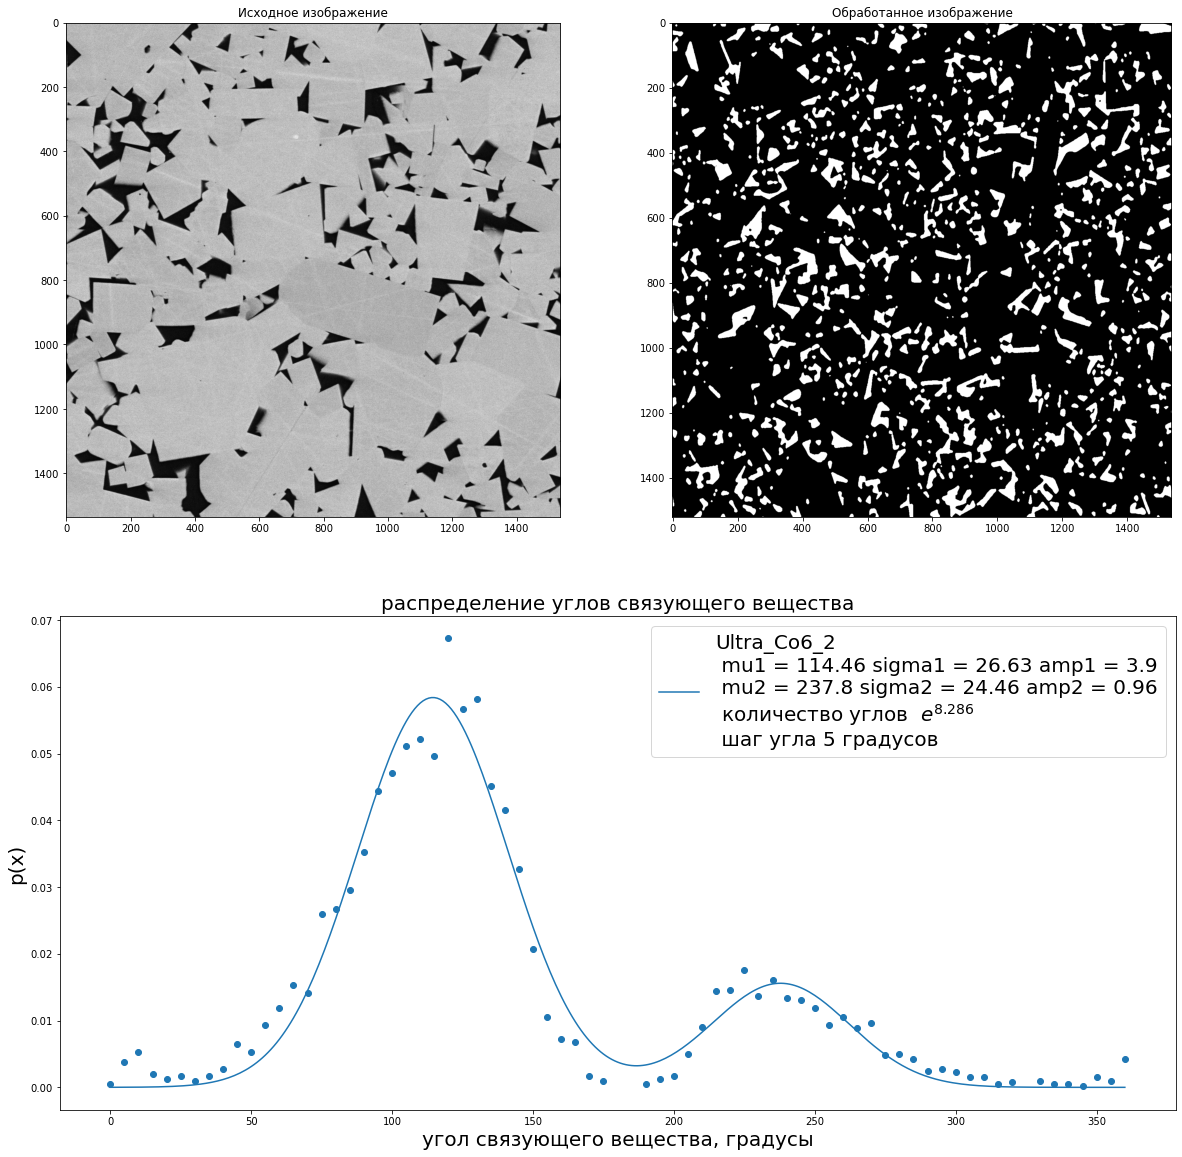

In [8]:
N=20

images=[image1,image2,image3,image4,image5]
origs=[grain1_pil,grain2_pil,grain3_pil,grain4_pil,grain5_pil]
images=[image2]
step=5
names=[grain1_name,grain2_name,grain3_name,grain4_name,grain5_name]
#names=['сплав с крупными зернами']
angles_approx(origs,images,names,step,N)

## Распределение диаметров

In [11]:
def diametr_approx(origins,images,names,step,pixel,N):
    text=[]
    bins=150
    
    for j,image in enumerate(images):

        a_beams,b_beams,angles,cetroids=grainMark.get_mvee_params(image,0.2)
        distances,dist_set,dens_curve=grainStats.stats_preprocess(a_beams,step)
        
        
        x1 = np.array([dist_set]).reshape(-1, 1)
        y1 = np.log([dens_curve]).reshape(-1, 1)
        norm1=round(np.sum(dens_curve),6)
        y1=y1/norm1

        x_linear1=np.arange(1,x1.max(axis=0)).reshape(-1, 1)
        reg1 = LinearRegression().fit(x1,y1)
        lin_predict1=reg1.predict(x_linear1)
        
        total_num=str(round(np.log(norm1),4))
        k1=round(reg1.coef_[0][0]*1000,3)
        score1=round(reg1.score(x1, y1),2)
        val=pixel*step
        num1='\n количество диаметров  $e^{'+total_num+'}$'
        lin_k1='\n k = '+str(k1)+'$*10^{-3}$'
        acc1='\n точность '+str(score1)
        text_step1='\n шаг длины диаметра '+str(val)+'$ мкм$'
        text1=names[j]+lin_k1+acc1+num1+text_step1
        
        distances,dist_set,dens_curve=grainStats.stats_preprocess(b_beams,step)
        
        x2 = np.array([dist_set]).reshape(-1, 1)
        y2 = np.log([dens_curve]).reshape(-1, 1)
        norm2=round(np.sum(dens_curve),6)
        y2=y2/norm2

        x_linear2=np.arange(1,x2.max(axis=0)).reshape(-1, 1)
        reg2 = LinearRegression().fit(x2,y2)
        lin_predict2=reg2.predict(x_linear2)
        
        k2=round(reg2.coef_[0][0]*1000,3)
        score2=round(reg2.score(x2, y2),2)
        val2=pixel*step

        num2='\n количество диаметров  $e^{'+total_num+'}$'
        lin_k2='\n k = '+str(k2)+'$*10^{-3}$'
        acc2='\n точность '+str(score2)
        text_step2='\n шаг длины диаметра '+str(val2)+'$ мкм$'
        text2=names[j]+lin_k2+acc2+num2+text_step2
        

        angles,angles_set,angles_dens_curve=grainStats.stats_preprocess(np.rad2deg(angles).astype('int32'),step=5)
        angle_norm=np.sum(angles_dens_curve)

        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize=(N,N))
        
        ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
        ax1.imshow(grainPreprocess.combine(origs[j],135,1),cmap='gray')
        ax1.set_title('Исходное изображение')

        ax2 = plt.subplot(gs[0, 1]) # row 0, col 1
        ax2.plot(angles_set,angles_dens_curve/angle_norm)
        ax2.set_title('Распределение углов наклона эллипса',fontsize=15)
        ax2.set_ylabel('p(x)', fontsize=20)
        ax2.set_xlabel('угол наклона, градусы', fontsize=20)

        ax3 = plt.subplot(gs[1, 0]) # row 1, span all columns
        ax3.plot(x_linear1*pixel,lin_predict1)
        ax3.scatter(x1*pixel,y1)
        
        ax3.legend([text1],fontsize=12)
        ax3.set_title('распределение a-полуосей связующего вещества', fontsize=15)
        ax3.set_ylabel('ln(p(x))', fontsize=20)
        ax3.set_xlabel('длина полуоси, мкм', fontsize=20)
        
        ax4 = plt.subplot(gs[1, 1]) # row 1, span all columns
        ax4.plot(x_linear2*pixel,lin_predict2)
        ax4.scatter(x2*pixel,y2)
        
        ax4.legend([text2],fontsize=12)
        ax4.set_title('распределение b-полуосей связующего вещества', fontsize=15)
        ax4.set_ylabel('ln(p(x))', fontsize=20)
        ax4.set_xlabel('длина полуоси, мкм', fontsize=20)

        
     #   f,ax=plt.subplots(nrows=2,ncols=1,figsize=(N,N))

    #    plt.hist(distances,bins=bins)
    #    plt.plot(x,np.log(y))
     #   ax[0].imshow(image,cmap='gray')
     #   ax[1].plot(x_linear*pixel,lin_predict)
    
    #    ax[1].scatter(x*pixel,y)
    #    val=pixel*step
    #    ax[1].legend([names[j]+'\n k = '+str(k)+'$*10^{-3}$ \n точность = '+str(score)+'\n количество диаметров  $e^{'+str(norm)+'}$'+'\n шаг длины диаметра '+str(val)+'$ мкм$'],fontsize=20)
    #    ax[1].set_title('распределение диаметров связующего вещества', fontsize=20)
    #    ax[1].set_ylabel('ln(p(x))', fontsize=20)
    #    ax[1].set_xlabel('диаметр региона связуюзего вещества, мкм', fontsize=20)
     #   plt.savefig('крупные_средние_мелкие.png')
        plt.savefig('диаметры_'+names[j])
        plt.show()

        
    


D:\PROJECTS\python\grain_segmentation\grain_utils.py:354: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:438: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:50: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D ima

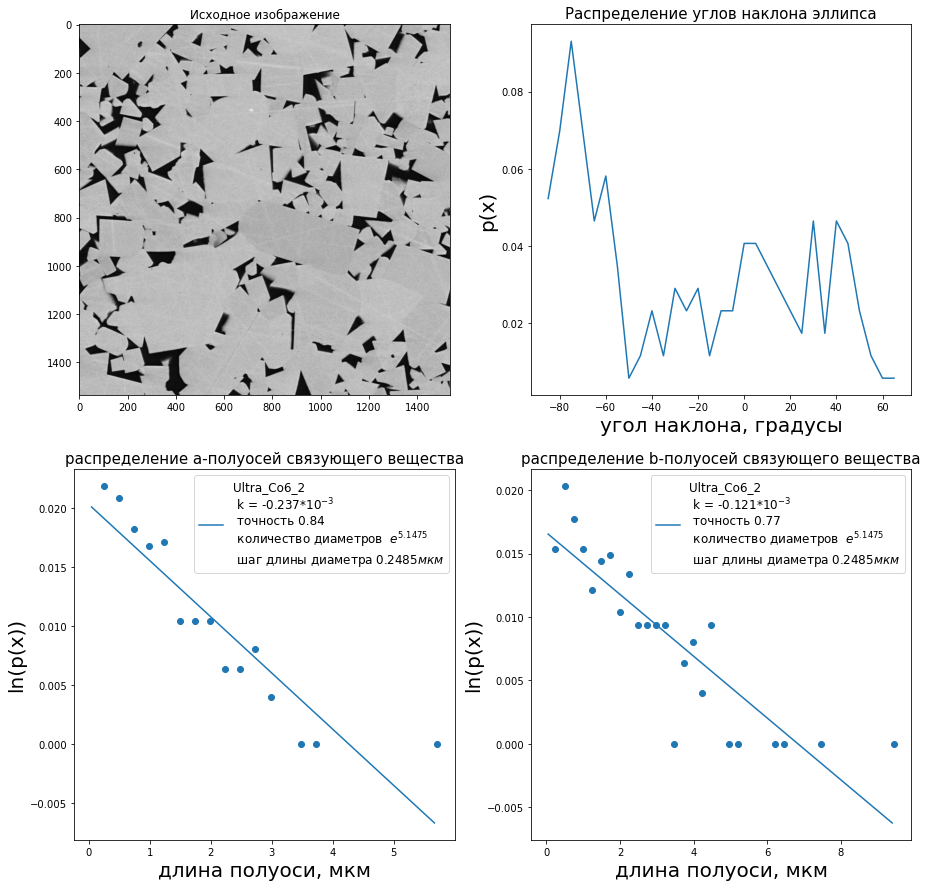

D:\PROJECTS\python\grain_segmentation\grain_utils.py:354: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:438: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:50: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D ima

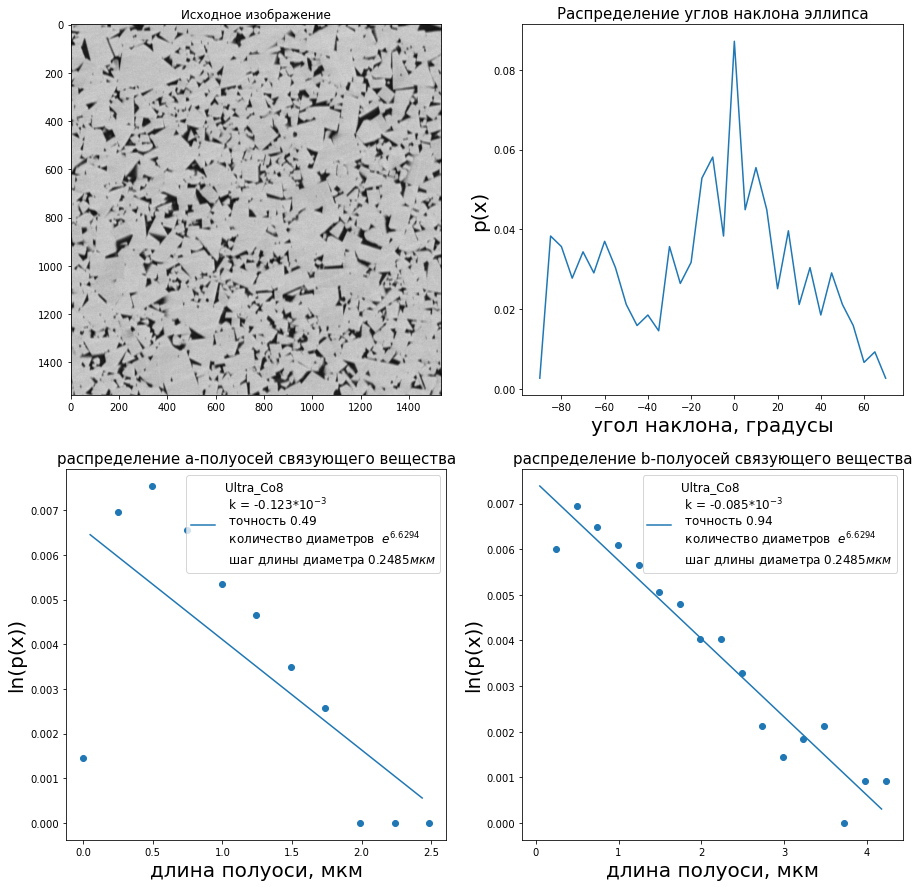

D:\PROJECTS\python\grain_segmentation\grain_utils.py:354: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:438: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:50: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D ima

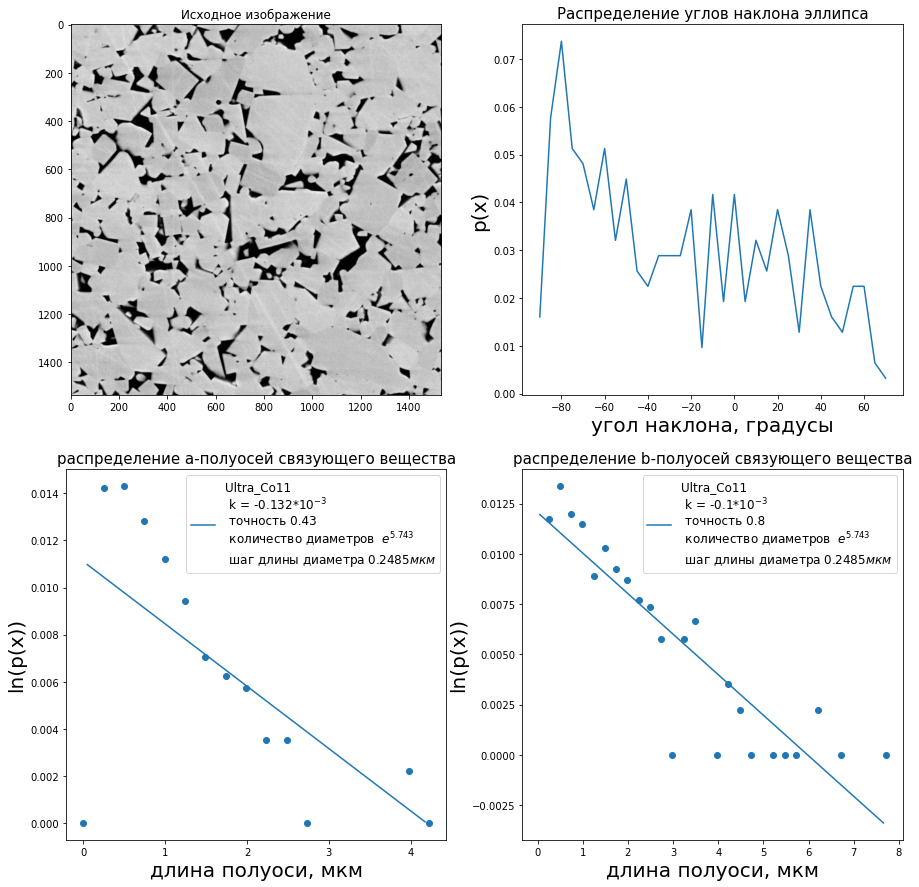

D:\PROJECTS\python\grain_segmentation\grain_utils.py:354: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:438: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:50: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D ima

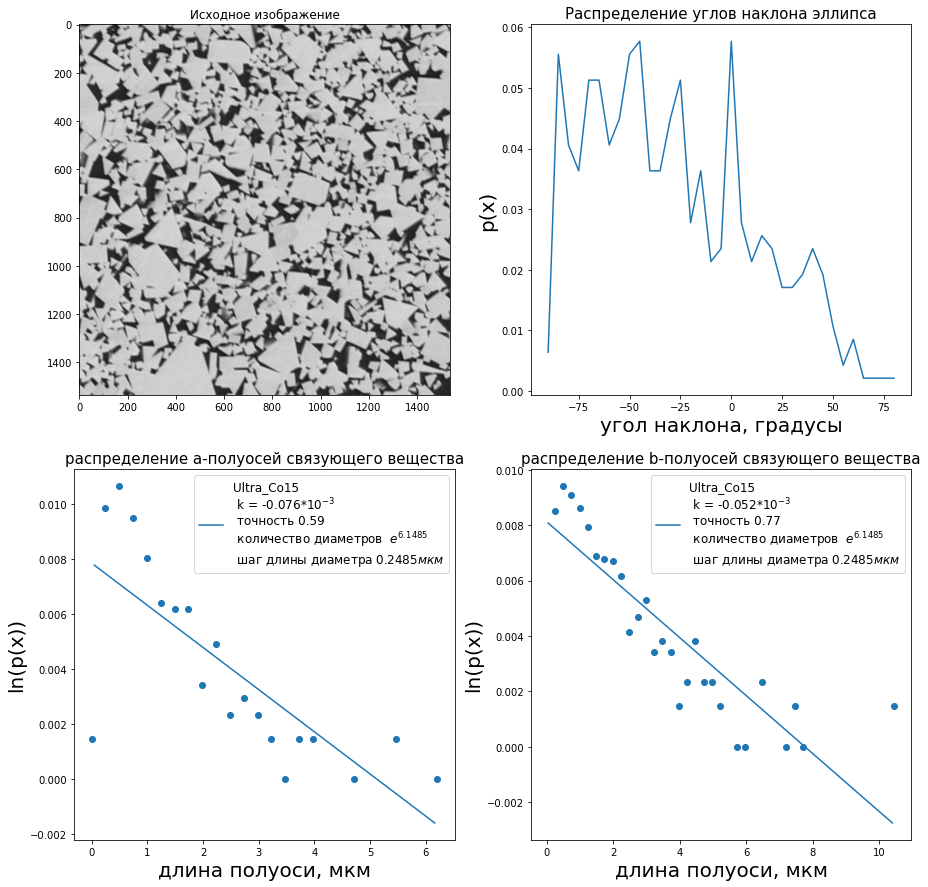

D:\PROJECTS\python\grain_segmentation\grain_utils.py:354: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:438: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)
D:\PROJECTS\python\grain_segmentation\grain_utils.py:50: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D ima

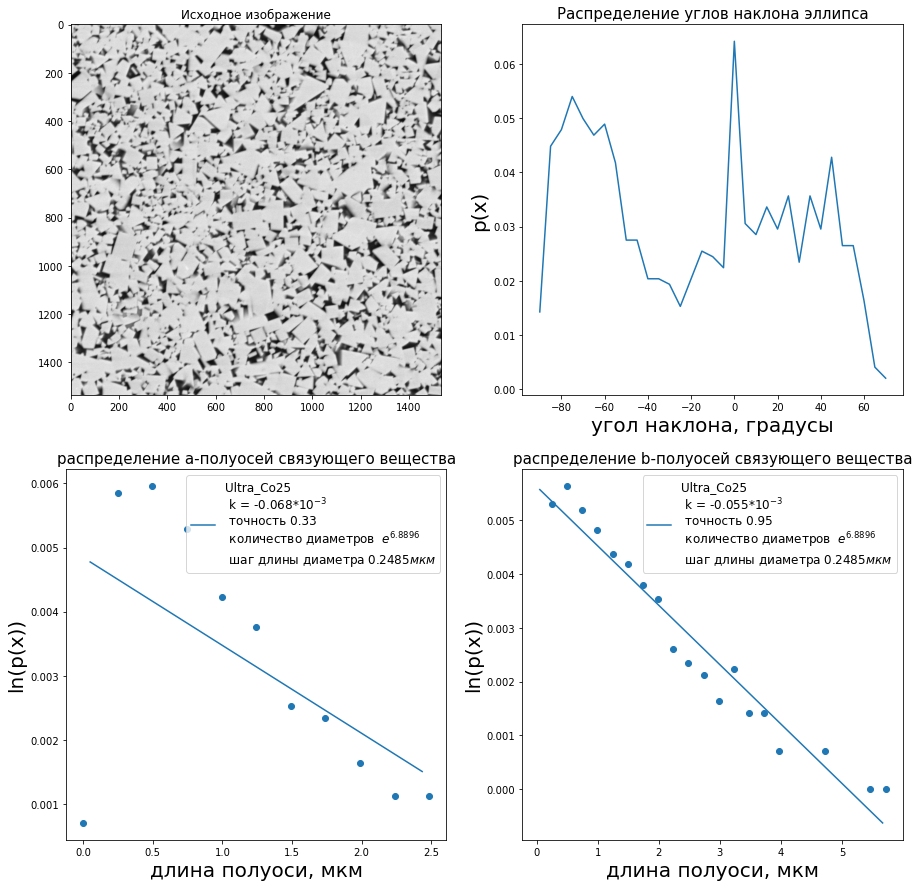

In [17]:
N=15
pixel=49.7/1000
images=[image1,image2,image3,image4,image5]
origs=[grain1_pil,grain2_pil,grain3_pil,grain4_pil,grain5_pil]
#images=[image2]
step=5
names=[grain1_name,grain2_name,grain3_name,grain4_name,grain5_name]
#names=['сплав с крупными зернами']
diametr_approx(origs,images,names,step,pixel,N)

In [11]:
image=image2
approx=grainMark.get_row_contours(image)

полуось а  17.84473997510457
полуось b  27.844451777900883
угол поворота  -1.1727603935352102


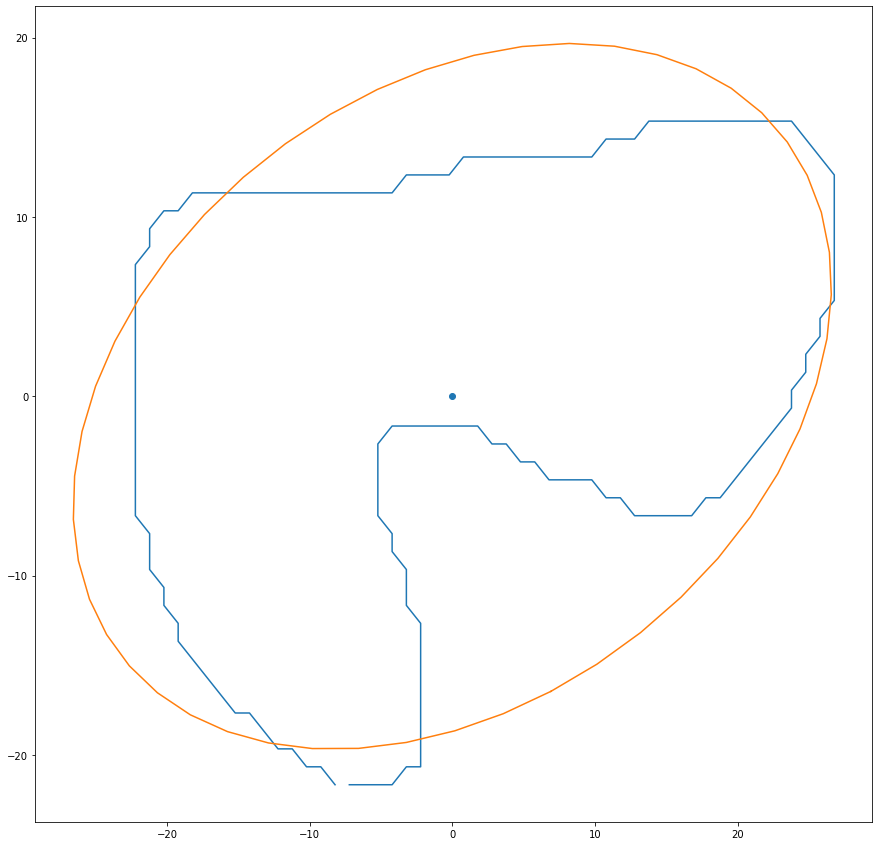

In [12]:
i=14

a_beams,b_beams,angles,cetroids=grainMark.get_mvee_params(image,0.2)
N=15
a=a_beams[i]
b=b_beams[i]
angle=angles[i]
print('полуось а ',a)
print('полуось b ',b)
print('угол поворота ',angle)

cnt=np.array(approx[i])

xp=cnt[:,0]
yp=cnt[:,1]
xc=cetroids[i,0]
yc=cetroids[i,1]

x,y= grainStats.ellipse(a,b,angle)
      
plt.figure(figsize=(N,N))
plt.plot(xp-xc,yp-yc)
plt.scatter(0,0)
plt.plot(x,y)

plt.show()


In [8]:
a_beams,b_beams,angles,centroids=grainMark.get_mvee_params(image)

## Распределение дуг

In [ ]:
cnts=grainMark.get_contours(arc)
img=grainDraw.draw_edges(skeleton*255,cnts)
#io.imsave('edges_skeleton.png',img)
#grainShow.img_show(img)

In [ ]:
from shapely.ops import triangulate # для установки shapely надо использовать conda install -c conda-forge shapely
from shapely.geometry import MultiPoint,Point,Polygon

In [ ]:
def get_inner_side(polygon,triangles):
    l_polygon=polygon.shape[0]

    sides=[]
    for triangle in triangles:
        l_triangle=triangle.shape[0]
        for i,t_point1 in enumerate(triangle[:l_triangle-1]):
            t_point2=triangle[i+1]
            for j,p_point1 in enumerate(polygon):
                if j==0 or j==l_polygon-1:
                    p_point2=polygon[-2]
                    p_point3=polygon[1]
                else:
                    p_point2=polygon[j-1]
                    p_point3=polygon[j+1]

                cond11= all([t_point1[0]==p_point1[0],
                           t_point1[1]==p_point1[1]])

                cond22= all([t_point2[0]==p_point2[0],
                           t_point2[1]==p_point2[1]])

                cond23= all([t_point2[0]==p_point3[0],
                           t_point2[1]==p_point3[1]])

                if cond11 and not (cond22 or cond23):
                    sides.append([t_point1,t_point2])
 

    for i,side1 in enumerate(sides):
        for j,side2 in enumerate(sides):
            cond1=all([side1[0][0]==side2[0][0],
                      side1[0][1]==side2[0][1]])
            
            cond2=all([side1[1][0]==side2[1][0],
                      side1[1][1]==side2[1][1]])
            if cond1 and cond2:
                sides.pop(j)
    
    return np.array(sides)


In [ ]:
def get_median_points(polygon,sides):
    points=[]
    for i,side in enumerate(sides):
        x=(side[0][0]+side[1][0])/2
        y=(side[0][1]+side[1][1])/2
        point=Point(x,y)
        if point.within(polygon) and x and y:
            points.append((x,y))
    return np.array(points)

In [ ]:
i=18
#27 супер кривой
M=10
data=cnts[i]
data[-1]=data[0]
polygon=np.array(data)

points = MultiPoint(data)
triangles = triangulate(points)
triang=[]
for triangle in triangles:
    triang.append(list(triangle.exterior.coords))
triang=np.array(triang)

sides=get_inner_side(polygon,triang)
poly=Polygon(data)
points=get_median_points(poly,sides)
plt.figure(figsize=(M,M))

#plt.scatter(points[:,0],points[:,1])


plt.plot(polygon[:,0],polygon[:,1])
plt.show()

In [ ]:

plt.plot(triang[0,:,0],triang[0,:,1])
plt.plot(triang[1,:,0],triang[1,:,1])
plt.plot(triang[2,:,0],triang[2,:,1])
#plt.plot(triang[3,:,0],triang[3,:,1])
#plt.plot(triang[4,:,0],triang[4,:,1])
plt.show()

In [ ]:
plt.plot()

In [ ]:
def triangulate_within(polygon):
    return [triangle for triangle in triangulate(polygon) if triangle.within(polygon)]

In [ ]:
new_triang=triangulate_within(points)

In [ ]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

In [ ]:

# Invert the horse image
#image = rgb2gray(io.imread('images/good_polygon1.jpg'))
image = rgb2gray(io.imread('images/good_polygon2.jpg'))==True
#image = rgb2gray(io.imread('images/bad_polygon.jpg'))==True
#image = rgb2gray(io.imread('images/a11.png'))
image=arc/255
#image=invert(image)
# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()